# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [1]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

--2021-03-09 11:25:23--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar.1’

VOCtrainval_11-May- 100%[===================>]   1.86G  47.0MB/s    in 42s     

2021-03-09 11:26:05 (45.8 MB/s) - ‘VOCtrainval_11-May-2012.tar.1’ saved [1999639040/1999639040]

VOCdevkit/
VOCdevkit/VOC2012/
VOCdevkit/VOC2012/Annotations/
VOCdevkit/VOC2012/Annotations/2007_000027.xml
VOCdevkit/VOC2012/Annotations/2007_000032.xml
VOCdevkit/VOC2012/Annotations/2007_000033.xml
VOCdevkit/VOC2012/Annotations/2007_000039.xml
VOCdevkit/VOC2012/Annotations/2007_000042.xml
VOCdevkit/VOC2012/Annotations/2007_000061.xml
VOCdevkit/VOC2012/Annotations/2007_000063.xml
VOCdevkit/VOC2012/Annotations/2007_000068

VOCdevkit/VOC2012/Annotations/2007_007810.xml
VOCdevkit/VOC2012/Annotations/2007_007815.xml
VOCdevkit/VOC2012/Annotations/2007_007818.xml
VOCdevkit/VOC2012/Annotations/2007_007836.xml
VOCdevkit/VOC2012/Annotations/2007_007849.xml
VOCdevkit/VOC2012/Annotations/2007_007871.xml
VOCdevkit/VOC2012/Annotations/2007_007877.xml
VOCdevkit/VOC2012/Annotations/2007_007878.xml
VOCdevkit/VOC2012/Annotations/2007_007881.xml
VOCdevkit/VOC2012/Annotations/2007_007890.xml
VOCdevkit/VOC2012/Annotations/2007_007891.xml
VOCdevkit/VOC2012/Annotations/2007_007892.xml
VOCdevkit/VOC2012/Annotations/2007_007902.xml
VOCdevkit/VOC2012/Annotations/2007_007908.xml
VOCdevkit/VOC2012/Annotations/2007_007910.xml
VOCdevkit/VOC2012/Annotations/2007_007917.xml
VOCdevkit/VOC2012/Annotations/2007_007930.xml
VOCdevkit/VOC2012/Annotations/2007_007940.xml
VOCdevkit/VOC2012/Annotations/2007_007947.xml
VOCdevkit/VOC2012/Annotations/2007_007948.xml
VOCdevkit/VOC2012/Annotations/2007_007955.xml
VOCdevkit/VOC2012/Annotations/2007

VOCdevkit/VOC2012/Annotations/2008_001322.xml
VOCdevkit/VOC2012/Annotations/2008_001325.xml
VOCdevkit/VOC2012/Annotations/2008_001329.xml
VOCdevkit/VOC2012/Annotations/2008_001333.xml
VOCdevkit/VOC2012/Annotations/2008_001334.xml
VOCdevkit/VOC2012/Annotations/2008_001335.xml
VOCdevkit/VOC2012/Annotations/2008_001336.xml
VOCdevkit/VOC2012/Annotations/2008_001338.xml
VOCdevkit/VOC2012/Annotations/2008_001340.xml
VOCdevkit/VOC2012/Annotations/2008_001344.xml
VOCdevkit/VOC2012/Annotations/2008_001346.xml
VOCdevkit/VOC2012/Annotations/2008_001349.xml
VOCdevkit/VOC2012/Annotations/2008_001350.xml
VOCdevkit/VOC2012/Annotations/2008_001351.xml
VOCdevkit/VOC2012/Annotations/2008_001353.xml
VOCdevkit/VOC2012/Annotations/2008_001356.xml
VOCdevkit/VOC2012/Annotations/2008_001357.xml
VOCdevkit/VOC2012/Annotations/2008_001358.xml
VOCdevkit/VOC2012/Annotations/2008_001359.xml
VOCdevkit/VOC2012/Annotations/2008_001366.xml
VOCdevkit/VOC2012/Annotations/2008_001367.xml
VOCdevkit/VOC2012/Annotations/2008

VOCdevkit/VOC2012/Annotations/2008_003213.xml
VOCdevkit/VOC2012/Annotations/2008_003220.xml
VOCdevkit/VOC2012/Annotations/2008_003222.xml
VOCdevkit/VOC2012/Annotations/2008_003224.xml
VOCdevkit/VOC2012/Annotations/2008_003225.xml
VOCdevkit/VOC2012/Annotations/2008_003228.xml
VOCdevkit/VOC2012/Annotations/2008_003231.xml
VOCdevkit/VOC2012/Annotations/2008_003232.xml
VOCdevkit/VOC2012/Annotations/2008_003238.xml
VOCdevkit/VOC2012/Annotations/2008_003239.xml
VOCdevkit/VOC2012/Annotations/2008_003242.xml
VOCdevkit/VOC2012/Annotations/2008_003244.xml
VOCdevkit/VOC2012/Annotations/2008_003245.xml
VOCdevkit/VOC2012/Annotations/2008_003248.xml
VOCdevkit/VOC2012/Annotations/2008_003249.xml
VOCdevkit/VOC2012/Annotations/2008_003251.xml
VOCdevkit/VOC2012/Annotations/2008_003252.xml
VOCdevkit/VOC2012/Annotations/2008_003255.xml
VOCdevkit/VOC2012/Annotations/2008_003256.xml
VOCdevkit/VOC2012/Annotations/2008_003261.xml
VOCdevkit/VOC2012/Annotations/2008_003263.xml
VOCdevkit/VOC2012/Annotations/2008

VOCdevkit/VOC2012/Annotations/2008_005127.xml
VOCdevkit/VOC2012/Annotations/2008_005132.xml
VOCdevkit/VOC2012/Annotations/2008_005133.xml
VOCdevkit/VOC2012/Annotations/2008_005134.xml
VOCdevkit/VOC2012/Annotations/2008_005136.xml
VOCdevkit/VOC2012/Annotations/2008_005137.xml
VOCdevkit/VOC2012/Annotations/2008_005139.xml
VOCdevkit/VOC2012/Annotations/2008_005140.xml
VOCdevkit/VOC2012/Annotations/2008_005145.xml
VOCdevkit/VOC2012/Annotations/2008_005146.xml
VOCdevkit/VOC2012/Annotations/2008_005147.xml
VOCdevkit/VOC2012/Annotations/2008_005150.xml
VOCdevkit/VOC2012/Annotations/2008_005151.xml
VOCdevkit/VOC2012/Annotations/2008_005156.xml
VOCdevkit/VOC2012/Annotations/2008_005158.xml
VOCdevkit/VOC2012/Annotations/2008_005159.xml
VOCdevkit/VOC2012/Annotations/2008_005160.xml
VOCdevkit/VOC2012/Annotations/2008_005166.xml
VOCdevkit/VOC2012/Annotations/2008_005167.xml
VOCdevkit/VOC2012/Annotations/2008_005168.xml
VOCdevkit/VOC2012/Annotations/2008_005171.xml
VOCdevkit/VOC2012/Annotations/2008

VOCdevkit/VOC2012/Annotations/2008_007075.xml
VOCdevkit/VOC2012/Annotations/2008_007076.xml
VOCdevkit/VOC2012/Annotations/2008_007081.xml
VOCdevkit/VOC2012/Annotations/2008_007082.xml
VOCdevkit/VOC2012/Annotations/2008_007084.xml
VOCdevkit/VOC2012/Annotations/2008_007085.xml
VOCdevkit/VOC2012/Annotations/2008_007086.xml
VOCdevkit/VOC2012/Annotations/2008_007090.xml
VOCdevkit/VOC2012/Annotations/2008_007091.xml
VOCdevkit/VOC2012/Annotations/2008_007095.xml
VOCdevkit/VOC2012/Annotations/2008_007096.xml
VOCdevkit/VOC2012/Annotations/2008_007097.xml
VOCdevkit/VOC2012/Annotations/2008_007098.xml
VOCdevkit/VOC2012/Annotations/2008_007101.xml
VOCdevkit/VOC2012/Annotations/2008_007103.xml
VOCdevkit/VOC2012/Annotations/2008_007105.xml
VOCdevkit/VOC2012/Annotations/2008_007106.xml
VOCdevkit/VOC2012/Annotations/2008_007108.xml
VOCdevkit/VOC2012/Annotations/2008_007112.xml
VOCdevkit/VOC2012/Annotations/2008_007114.xml
VOCdevkit/VOC2012/Annotations/2008_007115.xml
VOCdevkit/VOC2012/Annotations/2008

VOCdevkit/VOC2012/Annotations/2009_000522.xml
VOCdevkit/VOC2012/Annotations/2009_000523.xml
VOCdevkit/VOC2012/Annotations/2009_000525.xml
VOCdevkit/VOC2012/Annotations/2009_000526.xml
VOCdevkit/VOC2012/Annotations/2009_000527.xml
VOCdevkit/VOC2012/Annotations/2009_000529.xml
VOCdevkit/VOC2012/Annotations/2009_000532.xml
VOCdevkit/VOC2012/Annotations/2009_000535.xml
VOCdevkit/VOC2012/Annotations/2009_000536.xml
VOCdevkit/VOC2012/Annotations/2009_000539.xml
VOCdevkit/VOC2012/Annotations/2009_000542.xml
VOCdevkit/VOC2012/Annotations/2009_000544.xml
VOCdevkit/VOC2012/Annotations/2009_000545.xml
VOCdevkit/VOC2012/Annotations/2009_000546.xml
VOCdevkit/VOC2012/Annotations/2009_000547.xml
VOCdevkit/VOC2012/Annotations/2009_000549.xml
VOCdevkit/VOC2012/Annotations/2009_000550.xml
VOCdevkit/VOC2012/Annotations/2009_000552.xml
VOCdevkit/VOC2012/Annotations/2009_000553.xml
VOCdevkit/VOC2012/Annotations/2009_000557.xml
VOCdevkit/VOC2012/Annotations/2009_000558.xml
VOCdevkit/VOC2012/Annotations/2009

VOCdevkit/VOC2012/Annotations/2009_002772.xml
VOCdevkit/VOC2012/Annotations/2009_002774.xml
VOCdevkit/VOC2012/Annotations/2009_002777.xml
VOCdevkit/VOC2012/Annotations/2009_002778.xml
VOCdevkit/VOC2012/Annotations/2009_002779.xml
VOCdevkit/VOC2012/Annotations/2009_002780.xml
VOCdevkit/VOC2012/Annotations/2009_002784.xml
VOCdevkit/VOC2012/Annotations/2009_002785.xml
VOCdevkit/VOC2012/Annotations/2009_002789.xml
VOCdevkit/VOC2012/Annotations/2009_002790.xml
VOCdevkit/VOC2012/Annotations/2009_002791.xml
VOCdevkit/VOC2012/Annotations/2009_002792.xml
VOCdevkit/VOC2012/Annotations/2009_002798.xml
VOCdevkit/VOC2012/Annotations/2009_002799.xml
VOCdevkit/VOC2012/Annotations/2009_002800.xml
VOCdevkit/VOC2012/Annotations/2009_002803.xml
VOCdevkit/VOC2012/Annotations/2009_002806.xml
VOCdevkit/VOC2012/Annotations/2009_002807.xml
VOCdevkit/VOC2012/Annotations/2009_002808.xml
VOCdevkit/VOC2012/Annotations/2009_002809.xml
VOCdevkit/VOC2012/Annotations/2009_002813.xml
VOCdevkit/VOC2012/Annotations/2009

VOCdevkit/VOC2012/Annotations/2009_005081.xml
VOCdevkit/VOC2012/Annotations/2009_005082.xml
VOCdevkit/VOC2012/Annotations/2009_005083.xml
VOCdevkit/VOC2012/Annotations/2009_005084.xml
VOCdevkit/VOC2012/Annotations/2009_005085.xml
VOCdevkit/VOC2012/Annotations/2009_005086.xml
VOCdevkit/VOC2012/Annotations/2009_005087.xml
VOCdevkit/VOC2012/Annotations/2009_005089.xml
VOCdevkit/VOC2012/Annotations/2009_005094.xml
VOCdevkit/VOC2012/Annotations/2009_005095.xml
VOCdevkit/VOC2012/Annotations/2009_005098.xml
VOCdevkit/VOC2012/Annotations/2009_005102.xml
VOCdevkit/VOC2012/Annotations/2009_005103.xml
VOCdevkit/VOC2012/Annotations/2009_005104.xml
VOCdevkit/VOC2012/Annotations/2009_005107.xml
VOCdevkit/VOC2012/Annotations/2009_005111.xml
VOCdevkit/VOC2012/Annotations/2009_005114.xml
VOCdevkit/VOC2012/Annotations/2009_005118.xml
VOCdevkit/VOC2012/Annotations/2009_005119.xml
VOCdevkit/VOC2012/Annotations/2009_005120.xml
VOCdevkit/VOC2012/Annotations/2009_005126.xml
VOCdevkit/VOC2012/Annotations/2009

VOCdevkit/VOC2012/Annotations/2010_002124.xml
VOCdevkit/VOC2012/Annotations/2010_002127.xml
VOCdevkit/VOC2012/Annotations/2010_002128.xml
VOCdevkit/VOC2012/Annotations/2010_002129.xml
VOCdevkit/VOC2012/Annotations/2010_002130.xml
VOCdevkit/VOC2012/Annotations/2010_002132.xml
VOCdevkit/VOC2012/Annotations/2010_002133.xml
VOCdevkit/VOC2012/Annotations/2010_002136.xml
VOCdevkit/VOC2012/Annotations/2010_002137.xml
VOCdevkit/VOC2012/Annotations/2010_002138.xml
VOCdevkit/VOC2012/Annotations/2010_002139.xml
VOCdevkit/VOC2012/Annotations/2010_002141.xml
VOCdevkit/VOC2012/Annotations/2010_002142.xml
VOCdevkit/VOC2012/Annotations/2010_002143.xml
VOCdevkit/VOC2012/Annotations/2010_002146.xml
VOCdevkit/VOC2012/Annotations/2010_002147.xml
VOCdevkit/VOC2012/Annotations/2010_002149.xml
VOCdevkit/VOC2012/Annotations/2010_002150.xml
VOCdevkit/VOC2012/Annotations/2010_002152.xml
VOCdevkit/VOC2012/Annotations/2010_002154.xml
VOCdevkit/VOC2012/Annotations/2010_002161.xml
VOCdevkit/VOC2012/Annotations/2010

VOCdevkit/VOC2012/Annotations/2010_004447.xml
VOCdevkit/VOC2012/Annotations/2010_004448.xml
VOCdevkit/VOC2012/Annotations/2010_004450.xml
VOCdevkit/VOC2012/Annotations/2010_004451.xml
VOCdevkit/VOC2012/Annotations/2010_004455.xml
VOCdevkit/VOC2012/Annotations/2010_004456.xml
VOCdevkit/VOC2012/Annotations/2010_004457.xml
VOCdevkit/VOC2012/Annotations/2010_004459.xml
VOCdevkit/VOC2012/Annotations/2010_004460.xml
VOCdevkit/VOC2012/Annotations/2010_004461.xml
VOCdevkit/VOC2012/Annotations/2010_004466.xml
VOCdevkit/VOC2012/Annotations/2010_004467.xml
VOCdevkit/VOC2012/Annotations/2010_004469.xml
VOCdevkit/VOC2012/Annotations/2010_004472.xml
VOCdevkit/VOC2012/Annotations/2010_004475.xml
VOCdevkit/VOC2012/Annotations/2010_004476.xml
VOCdevkit/VOC2012/Annotations/2010_004477.xml
VOCdevkit/VOC2012/Annotations/2010_004478.xml
VOCdevkit/VOC2012/Annotations/2010_004479.xml
VOCdevkit/VOC2012/Annotations/2010_004481.xml
VOCdevkit/VOC2012/Annotations/2010_004483.xml
VOCdevkit/VOC2012/Annotations/2010

VOCdevkit/VOC2012/Annotations/2010_006354.xml
VOCdevkit/VOC2012/Annotations/2010_006355.xml
VOCdevkit/VOC2012/Annotations/2010_006356.xml
VOCdevkit/VOC2012/Annotations/2010_006357.xml
VOCdevkit/VOC2012/Annotations/2010_006358.xml
VOCdevkit/VOC2012/Annotations/2010_006363.xml
VOCdevkit/VOC2012/Annotations/2010_006364.xml
VOCdevkit/VOC2012/Annotations/2010_006365.xml
VOCdevkit/VOC2012/Annotations/2010_006372.xml
VOCdevkit/VOC2012/Annotations/2010_006375.xml
VOCdevkit/VOC2012/Annotations/2010_006376.xml
VOCdevkit/VOC2012/Annotations/2010_006378.xml
VOCdevkit/VOC2012/Annotations/2010_006380.xml
VOCdevkit/VOC2012/Annotations/2010_006382.xml
VOCdevkit/VOC2012/Annotations/2010_006385.xml
VOCdevkit/VOC2012/Annotations/2010_006386.xml
VOCdevkit/VOC2012/Annotations/2010_006387.xml
VOCdevkit/VOC2012/Annotations/2010_006390.xml
VOCdevkit/VOC2012/Annotations/2010_006392.xml
VOCdevkit/VOC2012/Annotations/2010_006394.xml
VOCdevkit/VOC2012/Annotations/2010_006395.xml
VOCdevkit/VOC2012/Annotations/2010

VOCdevkit/VOC2012/Annotations/2011_000690.xml
VOCdevkit/VOC2012/Annotations/2011_000692.xml
VOCdevkit/VOC2012/Annotations/2011_000696.xml
VOCdevkit/VOC2012/Annotations/2011_000698.xml
VOCdevkit/VOC2012/Annotations/2011_000700.xml
VOCdevkit/VOC2012/Annotations/2011_000701.xml
VOCdevkit/VOC2012/Annotations/2011_000703.xml
VOCdevkit/VOC2012/Annotations/2011_000704.xml
VOCdevkit/VOC2012/Annotations/2011_000709.xml
VOCdevkit/VOC2012/Annotations/2011_000711.xml
VOCdevkit/VOC2012/Annotations/2011_000713.xml
VOCdevkit/VOC2012/Annotations/2011_000716.xml
VOCdevkit/VOC2012/Annotations/2011_000718.xml
VOCdevkit/VOC2012/Annotations/2011_000720.xml
VOCdevkit/VOC2012/Annotations/2011_000724.xml
VOCdevkit/VOC2012/Annotations/2011_000725.xml
VOCdevkit/VOC2012/Annotations/2011_000730.xml
VOCdevkit/VOC2012/Annotations/2011_000731.xml
VOCdevkit/VOC2012/Annotations/2011_000732.xml
VOCdevkit/VOC2012/Annotations/2011_000734.xml
VOCdevkit/VOC2012/Annotations/2011_000743.xml
VOCdevkit/VOC2012/Annotations/2011

VOCdevkit/VOC2012/Annotations/2011_002278.xml
VOCdevkit/VOC2012/Annotations/2011_002279.xml
VOCdevkit/VOC2012/Annotations/2011_002280.xml
VOCdevkit/VOC2012/Annotations/2011_002281.xml
VOCdevkit/VOC2012/Annotations/2011_002284.xml
VOCdevkit/VOC2012/Annotations/2011_002286.xml
VOCdevkit/VOC2012/Annotations/2011_002287.xml
VOCdevkit/VOC2012/Annotations/2011_002291.xml
VOCdevkit/VOC2012/Annotations/2011_002292.xml
VOCdevkit/VOC2012/Annotations/2011_002294.xml
VOCdevkit/VOC2012/Annotations/2011_002295.xml
VOCdevkit/VOC2012/Annotations/2011_002298.xml
VOCdevkit/VOC2012/Annotations/2011_002300.xml
VOCdevkit/VOC2012/Annotations/2011_002301.xml
VOCdevkit/VOC2012/Annotations/2011_002303.xml
VOCdevkit/VOC2012/Annotations/2011_002308.xml
VOCdevkit/VOC2012/Annotations/2011_002309.xml
VOCdevkit/VOC2012/Annotations/2011_002312.xml
VOCdevkit/VOC2012/Annotations/2011_002313.xml
VOCdevkit/VOC2012/Annotations/2011_002317.xml
VOCdevkit/VOC2012/Annotations/2011_002318.xml
VOCdevkit/VOC2012/Annotations/2011

VOCdevkit/VOC2012/Annotations/2011_004158.xml
VOCdevkit/VOC2012/Annotations/2011_004161.xml
VOCdevkit/VOC2012/Annotations/2011_004163.xml
VOCdevkit/VOC2012/Annotations/2011_004165.xml
VOCdevkit/VOC2012/Annotations/2011_004170.xml
VOCdevkit/VOC2012/Annotations/2011_004172.xml
VOCdevkit/VOC2012/Annotations/2011_004173.xml
VOCdevkit/VOC2012/Annotations/2011_004176.xml
VOCdevkit/VOC2012/Annotations/2011_004177.xml
VOCdevkit/VOC2012/Annotations/2011_004179.xml
VOCdevkit/VOC2012/Annotations/2011_004180.xml
VOCdevkit/VOC2012/Annotations/2011_004183.xml
VOCdevkit/VOC2012/Annotations/2011_004185.xml
VOCdevkit/VOC2012/Annotations/2011_004188.xml
VOCdevkit/VOC2012/Annotations/2011_004190.xml
VOCdevkit/VOC2012/Annotations/2011_004193.xml
VOCdevkit/VOC2012/Annotations/2011_004194.xml
VOCdevkit/VOC2012/Annotations/2011_004197.xml
VOCdevkit/VOC2012/Annotations/2011_004199.xml
VOCdevkit/VOC2012/Annotations/2011_004200.xml
VOCdevkit/VOC2012/Annotations/2011_004202.xml
VOCdevkit/VOC2012/Annotations/2011

VOCdevkit/VOC2012/Annotations/2011_006018.xml
VOCdevkit/VOC2012/Annotations/2011_006019.xml
VOCdevkit/VOC2012/Annotations/2011_006020.xml
VOCdevkit/VOC2012/Annotations/2011_006021.xml
VOCdevkit/VOC2012/Annotations/2011_006022.xml
VOCdevkit/VOC2012/Annotations/2011_006025.xml
VOCdevkit/VOC2012/Annotations/2011_006028.xml
VOCdevkit/VOC2012/Annotations/2011_006029.xml
VOCdevkit/VOC2012/Annotations/2011_006034.xml
VOCdevkit/VOC2012/Annotations/2011_006036.xml
VOCdevkit/VOC2012/Annotations/2011_006039.xml
VOCdevkit/VOC2012/Annotations/2011_006044.xml
VOCdevkit/VOC2012/Annotations/2011_006046.xml
VOCdevkit/VOC2012/Annotations/2011_006051.xml
VOCdevkit/VOC2012/Annotations/2011_006053.xml
VOCdevkit/VOC2012/Annotations/2011_006054.xml
VOCdevkit/VOC2012/Annotations/2011_006057.xml
VOCdevkit/VOC2012/Annotations/2011_006058.xml
VOCdevkit/VOC2012/Annotations/2011_006060.xml
VOCdevkit/VOC2012/Annotations/2011_006063.xml
VOCdevkit/VOC2012/Annotations/2011_006065.xml
VOCdevkit/VOC2012/Annotations/2011

VOCdevkit/VOC2012/Annotations/2012_000126.xml
VOCdevkit/VOC2012/Annotations/2012_000127.xml
VOCdevkit/VOC2012/Annotations/2012_000132.xml
VOCdevkit/VOC2012/Annotations/2012_000136.xml
VOCdevkit/VOC2012/Annotations/2012_000137.xml
VOCdevkit/VOC2012/Annotations/2012_000138.xml
VOCdevkit/VOC2012/Annotations/2012_000139.xml
VOCdevkit/VOC2012/Annotations/2012_000142.xml
VOCdevkit/VOC2012/Annotations/2012_000144.xml
VOCdevkit/VOC2012/Annotations/2012_000145.xml
VOCdevkit/VOC2012/Annotations/2012_000150.xml
VOCdevkit/VOC2012/Annotations/2012_000152.xml
VOCdevkit/VOC2012/Annotations/2012_000154.xml
VOCdevkit/VOC2012/Annotations/2012_000156.xml
VOCdevkit/VOC2012/Annotations/2012_000160.xml
VOCdevkit/VOC2012/Annotations/2012_000162.xml
VOCdevkit/VOC2012/Annotations/2012_000166.xml
VOCdevkit/VOC2012/Annotations/2012_000168.xml
VOCdevkit/VOC2012/Annotations/2012_000169.xml
VOCdevkit/VOC2012/Annotations/2012_000171.xml
VOCdevkit/VOC2012/Annotations/2012_000172.xml
VOCdevkit/VOC2012/Annotations/2012

VOCdevkit/VOC2012/Annotations/2012_001651.xml
VOCdevkit/VOC2012/Annotations/2012_001653.xml
VOCdevkit/VOC2012/Annotations/2012_001654.xml
VOCdevkit/VOC2012/Annotations/2012_001655.xml
VOCdevkit/VOC2012/Annotations/2012_001656.xml
VOCdevkit/VOC2012/Annotations/2012_001657.xml
VOCdevkit/VOC2012/Annotations/2012_001658.xml
VOCdevkit/VOC2012/Annotations/2012_001659.xml
VOCdevkit/VOC2012/Annotations/2012_001660.xml
VOCdevkit/VOC2012/Annotations/2012_001662.xml
VOCdevkit/VOC2012/Annotations/2012_001663.xml
VOCdevkit/VOC2012/Annotations/2012_001664.xml
VOCdevkit/VOC2012/Annotations/2012_001665.xml
VOCdevkit/VOC2012/Annotations/2012_001666.xml
VOCdevkit/VOC2012/Annotations/2012_001667.xml
VOCdevkit/VOC2012/Annotations/2012_001670.xml
VOCdevkit/VOC2012/Annotations/2012_001671.xml
VOCdevkit/VOC2012/Annotations/2012_001672.xml
VOCdevkit/VOC2012/Annotations/2012_001673.xml
VOCdevkit/VOC2012/Annotations/2012_001674.xml
VOCdevkit/VOC2012/Annotations/2012_001676.xml
VOCdevkit/VOC2012/Annotations/2012

VOCdevkit/VOC2012/Annotations/2012_003415.xml
VOCdevkit/VOC2012/Annotations/2012_003416.xml
VOCdevkit/VOC2012/Annotations/2012_003419.xml
VOCdevkit/VOC2012/Annotations/2012_003420.xml
VOCdevkit/VOC2012/Annotations/2012_003426.xml
VOCdevkit/VOC2012/Annotations/2012_003429.xml
VOCdevkit/VOC2012/Annotations/2012_003431.xml
VOCdevkit/VOC2012/Annotations/2012_003432.xml
VOCdevkit/VOC2012/Annotations/2012_003434.xml
VOCdevkit/VOC2012/Annotations/2012_003435.xml
VOCdevkit/VOC2012/Annotations/2012_003436.xml
VOCdevkit/VOC2012/Annotations/2012_003438.xml
VOCdevkit/VOC2012/Annotations/2012_003440.xml
VOCdevkit/VOC2012/Annotations/2012_003441.xml
VOCdevkit/VOC2012/Annotations/2012_003443.xml
VOCdevkit/VOC2012/Annotations/2012_003444.xml
VOCdevkit/VOC2012/Annotations/2012_003445.xml
VOCdevkit/VOC2012/Annotations/2012_003447.xml
VOCdevkit/VOC2012/Annotations/2012_003448.xml
VOCdevkit/VOC2012/Annotations/2012_003453.xml
VOCdevkit/VOC2012/Annotations/2012_003454.xml
VOCdevkit/VOC2012/Annotations/2012

VOCdevkit/VOC2012/JPEGImages/2007_000661.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000663.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000664.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000676.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000713.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000720.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000727.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000733.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000738.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000762.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000768.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000783.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000793.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000799.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000804.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000807.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000822.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000830.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000836.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000837.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000847.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000862.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2007_005019.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005043.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005058.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005064.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005074.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005086.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005107.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005114.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005124.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005130.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005144.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005149.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005173.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005206.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005210.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005212.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005227.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005248.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005262.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005264.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005266.jpg
VOCdevkit/VOC2012/JPEGImages/2007_005273.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2007_008815.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008816.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008821.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008897.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008921.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008927.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008932.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008944.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008945.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008948.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008964.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008973.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008980.jpg
VOCdevkit/VOC2012/JPEGImages/2007_008994.jpg
VOCdevkit/VOC2012/JPEGImages/2007_009015.jpg
VOCdevkit/VOC2012/JPEGImages/2007_009030.jpg
VOCdevkit/VOC2012/JPEGImages/2007_009040.jpg
VOCdevkit/VOC2012/JPEGImages/2007_009052.jpg
VOCdevkit/VOC2012/JPEGImages/2007_009068.jpg
VOCdevkit/VOC2012/JPEGImages/2007_009082.jpg
VOCdevkit/VOC2012/JPEGImages/2007_009084.jpg
VOCdevkit/VOC2012/JPEGImages/2007_009088.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_000342.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000343.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000345.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000346.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000348.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000350.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000354.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000356.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000358.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000359.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000361.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000364.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000365.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000367.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000371.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000373.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000376.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000378.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000380.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000381.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000382.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000383.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_000853.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000854.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000857.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000858.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000860.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000861.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000863.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000864.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000867.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000868.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000870.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000873.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000875.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000876.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000878.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000880.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000881.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000883.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000884.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000885.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000887.jpg
VOCdevkit/VOC2012/JPEGImages/2008_000897.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_001388.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001389.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001390.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001391.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001395.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001399.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001401.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001402.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001404.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001405.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001406.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001408.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001410.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001413.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001414.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001415.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001419.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001420.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001427.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001428.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001429.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001430.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_001865.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001866.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001867.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001869.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001871.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001872.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001874.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001876.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001880.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001881.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001882.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001885.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001888.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001894.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001895.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001896.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001899.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001903.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001905.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001907.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001908.jpg
VOCdevkit/VOC2012/JPEGImages/2008_001909.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_002404.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002405.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002408.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002410.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002411.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002412.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002414.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002418.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002419.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002422.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002424.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002425.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002428.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002429.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002430.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002434.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002436.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002437.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002438.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002439.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002441.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002442.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_002916.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002917.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002920.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002922.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002926.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002929.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002930.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002931.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002932.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002936.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002942.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002943.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002946.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002947.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002948.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002951.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002954.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002955.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002956.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002957.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002958.jpg
VOCdevkit/VOC2012/JPEGImages/2008_002960.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_003451.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003452.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003453.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003458.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003461.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003462.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003463.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003464.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003466.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003467.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003469.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003472.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003475.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003476.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003477.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003478.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003479.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003480.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003482.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003483.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003484.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003485.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_003975.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003976.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003978.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003983.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003984.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003985.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003986.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003988.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003989.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003992.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003995.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003996.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003997.jpg
VOCdevkit/VOC2012/JPEGImages/2008_003998.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004000.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004002.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004003.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004004.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004006.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004007.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004008.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004014.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_004515.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004518.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004519.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004520.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004522.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004525.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004526.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004528.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004532.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004533.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004534.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004538.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004539.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004540.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004541.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004544.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004545.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004546.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004547.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004549.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004550.jpg
VOCdevkit/VOC2012/JPEGImages/2008_004551.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_005032.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005033.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005035.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005036.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005037.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005040.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005042.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005043.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005045.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005046.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005049.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005051.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005054.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005055.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005057.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005061.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005063.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005064.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005065.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005066.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005068.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005070.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_005614.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005616.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005618.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005623.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005625.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005626.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005627.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005628.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005631.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005633.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005634.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005635.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005636.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005637.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005638.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005639.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005641.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005642.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005643.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005646.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005649.jpg
VOCdevkit/VOC2012/JPEGImages/2008_005650.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_006218.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006219.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006220.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006221.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006222.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006224.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006225.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006227.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006229.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006232.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006233.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006234.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006235.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006239.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006240.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006242.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006244.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006249.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006250.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006253.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006254.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006256.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_006833.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006834.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006835.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006837.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006839.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006841.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006843.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006844.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006847.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006849.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006855.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006857.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006863.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006864.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006865.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006868.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006870.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006872.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006873.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006874.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006877.jpg
VOCdevkit/VOC2012/JPEGImages/2008_006879.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_007441.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007442.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007443.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007444.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007446.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007448.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007452.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007455.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007456.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007458.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007459.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007461.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007465.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007466.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007469.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007470.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007471.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007472.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007473.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007476.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007477.jpg
VOCdevkit/VOC2012/JPEGImages/2008_007478.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_008007.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008011.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008012.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008018.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008020.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008021.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008022.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008024.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008025.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008028.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008029.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008031.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008034.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008037.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008040.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008043.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008044.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008048.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008050.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008051.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008052.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008053.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2008_008552.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008554.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008560.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008564.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008567.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008570.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008572.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008574.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008578.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008579.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008583.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008585.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008588.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008589.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008590.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008591.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008593.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008595.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008598.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008600.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008601.jpg
VOCdevkit/VOC2012/JPEGImages/2008_008606.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2009_000316.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000317.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000318.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000320.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000321.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000322.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000327.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000328.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000330.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000335.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000336.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000337.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000339.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000340.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000341.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000342.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000343.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000344.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000347.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000350.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000351.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000354.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2009_000823.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000824.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000825.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000828.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000829.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000830.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000831.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000833.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000834.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000837.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000839.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000840.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000843.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000845.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000846.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000848.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000849.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000851.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000852.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000854.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000856.jpg
VOCdevkit/VOC2012/JPEGImages/2009_000858.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2009_001313.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001314.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001316.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001319.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001320.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001321.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001322.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001323.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001326.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001327.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001328.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001329.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001332.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001333.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001339.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001343.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001344.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001345.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001348.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001349.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001350.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001354.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2009_001801.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001802.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001804.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001805.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001806.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001807.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001809.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001810.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001811.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001812.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001816.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001817.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001818.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001820.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001822.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001823.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001825.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001826.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001827.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001828.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001830.jpg
VOCdevkit/VOC2012/JPEGImages/2009_001831.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2009_002306.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002308.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002311.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002312.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002314.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002317.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002319.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002320.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002324.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002325.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002326.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002328.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002331.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002333.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002335.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002338.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002339.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002343.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002346.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002348.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002349.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002350.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2009_002842.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002843.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002844.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002845.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002847.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002849.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002850.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002851.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002853.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002855.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002856.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002862.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002865.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002867.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002869.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002872.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002876.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002877.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002879.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002882.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002883.jpg
VOCdevkit/VOC2012/JPEGImages/2009_002885.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2009_003346.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003347.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003348.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003349.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003350.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003351.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003352.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003353.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003360.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003361.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003363.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003365.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003367.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003369.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003372.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003373.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003375.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003376.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003377.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003378.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003379.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003380.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2009_003786.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003790.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003793.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003795.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003799.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003800.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003801.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003802.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003804.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003805.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003806.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003808.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003810.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003813.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003814.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003815.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003816.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003818.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003819.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003820.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003821.jpg
VOCdevkit/VOC2012/JPEGImages/2009_003822.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2009_004159.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004161.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004162.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004163.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004164.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004165.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004166.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004168.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004169.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004170.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004171.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004173.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004174.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004175.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004176.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004177.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004178.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004179.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004180.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004181.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004183.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004186.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2009_004579.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004580.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004581.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004582.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004587.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004588.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004590.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004592.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004593.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004594.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004598.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004601.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004606.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004607.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004614.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004616.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004619.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004620.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004623.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004624.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004625.jpg
VOCdevkit/VOC2012/JPEGImages/2009_004626.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2009_005055.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005056.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005057.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005060.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005061.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005062.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005064.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005068.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005069.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005070.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005073.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005075.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005076.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005078.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005079.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005080.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005081.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005082.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005083.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005084.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005085.jpg
VOCdevkit/VOC2012/JPEGImages/2009_005086.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_000245.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000246.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000247.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000248.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000249.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000250.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000254.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000255.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000256.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000260.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000261.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000262.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000263.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000264.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000266.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000269.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000270.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000272.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000273.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000276.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000279.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000283.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_000744.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000746.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000747.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000748.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000749.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000750.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000754.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000759.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000760.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000761.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000764.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000765.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000769.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000770.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000771.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000772.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000773.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000778.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000782.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000785.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000786.jpg
VOCdevkit/VOC2012/JPEGImages/2010_000787.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_001261.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001263.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001264.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001270.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001271.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001272.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001273.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001274.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001275.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001277.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001279.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001282.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001286.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001287.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001288.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001289.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001291.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001292.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001293.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001294.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001299.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001301.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_001768.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001770.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001771.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001773.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001776.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001777.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001780.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001783.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001784.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001785.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001787.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001788.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001794.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001795.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001796.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001797.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001801.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001803.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001806.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001807.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001808.jpg
VOCdevkit/VOC2012/JPEGImages/2010_001810.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_002294.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002295.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002299.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002301.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002303.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002305.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002307.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002309.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002310.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002312.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002313.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002315.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002316.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002318.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002319.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002320.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002321.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002326.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002327.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002332.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002333.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002336.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_002783.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002786.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002789.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002790.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002791.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002792.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002793.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002794.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002797.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002801.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002803.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002805.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002807.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002808.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002811.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002813.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002814.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002815.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002816.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002817.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002820.jpg
VOCdevkit/VOC2012/JPEGImages/2010_002821.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_003278.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003279.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003280.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003283.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003285.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003287.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003290.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003291.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003293.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003297.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003299.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003300.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003301.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003302.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003303.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003304.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003305.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003309.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003314.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003316.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003321.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003325.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_003792.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003798.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003799.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003800.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003801.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003804.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003805.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003806.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003807.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003811.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003813.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003815.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003816.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003818.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003820.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003821.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003822.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003823.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003825.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003826.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003828.jpg
VOCdevkit/VOC2012/JPEGImages/2010_003837.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_004360.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004361.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004362.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004363.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004365.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004366.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004367.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004368.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004369.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004370.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004371.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004373.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004374.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004380.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004382.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004385.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004387.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004390.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004391.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004400.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004402.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004404.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_004973.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004974.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004980.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004982.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004983.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004987.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004989.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004991.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004992.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004994.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004995.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004997.jpg
VOCdevkit/VOC2012/JPEGImages/2010_004998.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005000.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005002.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005005.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005006.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005008.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005011.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005013.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005016.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005017.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_005566.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005567.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005570.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005571.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005572.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005573.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005575.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005576.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005578.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005582.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005584.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005585.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005586.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005587.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005588.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005591.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005592.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005593.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005594.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005595.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005596.jpg
VOCdevkit/VOC2012/JPEGImages/2010_005597.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_006197.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006200.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006201.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006202.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006204.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006206.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006207.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006209.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006210.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006211.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006213.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006214.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006215.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006217.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006218.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006219.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006220.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006222.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006225.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006229.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006230.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006231.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2010_006815.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006816.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006817.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006819.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006822.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006823.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006825.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006826.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006829.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006833.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006837.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006838.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006839.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006841.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006845.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006846.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006848.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006852.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006854.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006855.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006856.jpg
VOCdevkit/VOC2012/JPEGImages/2010_006857.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2011_000426.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000427.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000428.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000430.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000432.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000433.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000434.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000435.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000436.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000438.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000442.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000444.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000445.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000449.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000450.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000453.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000454.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000455.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000456.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000457.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000458.jpg
VOCdevkit/VOC2012/JPEGImages/2011_000461.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2011_001022.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001023.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001025.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001027.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001028.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001029.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001030.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001031.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001032.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001033.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001034.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001036.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001038.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001040.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001043.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001044.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001047.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001052.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001054.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001055.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001056.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001058.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2011_001622.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001624.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001625.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001627.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001628.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001629.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001632.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001637.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001641.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001642.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001643.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001645.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001647.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001649.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001650.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001652.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001653.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001655.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001656.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001662.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001663.jpg
VOCdevkit/VOC2012/JPEGImages/2011_001665.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2011_002191.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002192.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002193.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002196.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002200.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002202.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002203.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002211.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002212.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002215.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002217.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002218.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002221.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002222.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002223.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002224.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002226.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002227.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002228.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002230.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002234.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002236.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2011_002838.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002841.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002842.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002851.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002852.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002853.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002854.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002857.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002863.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002864.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002867.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002868.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002870.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002871.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002872.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002873.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002877.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002879.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002880.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002881.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002883.jpg
VOCdevkit/VOC2012/JPEGImages/2011_002884.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2011_003482.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003483.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003484.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003486.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003488.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003490.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003491.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003492.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003493.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003494.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003495.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003497.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003505.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003506.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003511.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003513.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003514.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003515.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003516.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003518.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003520.jpg
VOCdevkit/VOC2012/JPEGImages/2011_003522.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2011_004170.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004172.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004173.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004176.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004177.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004179.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004180.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004183.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004185.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004188.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004190.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004193.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004194.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004197.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004199.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004200.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004202.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004208.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004209.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004213.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004214.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004215.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2011_004799.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004801.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004802.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004804.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004809.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004810.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004816.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004821.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004822.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004823.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004824.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004829.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004830.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004834.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004836.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004838.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004839.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004840.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004844.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004847.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004850.jpg
VOCdevkit/VOC2012/JPEGImages/2011_004854.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2011_005513.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005517.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005518.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005519.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005520.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005523.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005524.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005525.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005526.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005529.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005531.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005533.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005534.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005535.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005539.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005541.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005542.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005543.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005544.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005545.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005550.jpg
VOCdevkit/VOC2012/JPEGImages/2011_005553.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2011_006128.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006132.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006134.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006135.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006136.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006139.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006141.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006142.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006146.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006147.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006148.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006149.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006150.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006151.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006153.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006155.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006157.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006159.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006161.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006162.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006165.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006166.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2011_006763.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006764.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006768.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006769.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006774.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006777.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006778.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006779.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006781.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006784.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006786.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006788.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006790.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006793.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006794.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006796.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006798.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006800.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006801.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006804.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006806.jpg
VOCdevkit/VOC2012/JPEGImages/2011_006807.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2012_000180.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000184.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000185.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000187.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000190.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000192.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000195.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000196.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000198.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000204.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000206.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000207.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000212.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000214.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000217.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000218.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000219.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000220.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000222.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000227.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000229.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000234.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2012_000910.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000911.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000912.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000913.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000914.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000915.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000917.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000918.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000919.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000924.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000931.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000932.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000934.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000937.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000938.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000940.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000941.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000942.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000946.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000947.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000949.jpg
VOCdevkit/VOC2012/JPEGImages/2012_000956.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2012_001460.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001465.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001466.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001469.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001472.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001475.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001476.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001477.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001478.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001482.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001483.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001485.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001486.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001487.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001491.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001493.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001498.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001499.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001501.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001502.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001503.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001504.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2012_001960.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001961.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001963.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001966.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001967.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001969.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001974.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001976.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001981.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001983.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001985.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001986.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001987.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001991.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001995.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001997.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001998.jpg
VOCdevkit/VOC2012/JPEGImages/2012_001999.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002002.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002004.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002005.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002007.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2012_002411.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002412.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002414.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002415.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002417.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002419.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002421.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002423.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002424.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002425.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002426.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002427.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002428.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002430.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002431.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002434.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002435.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002437.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002440.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002442.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002443.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002444.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2012_002949.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002952.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002955.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002956.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002957.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002961.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002963.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002964.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002969.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002970.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002972.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002973.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002974.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002976.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002979.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002982.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002983.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002985.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002986.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002992.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002993.jpg
VOCdevkit/VOC2012/JPEGImages/2012_002995.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2012_003507.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003508.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003510.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003513.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003518.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003520.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003521.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003523.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003524.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003528.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003529.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003530.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003533.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003535.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003538.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003539.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003540.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003545.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003548.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003553.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003555.jpg
VOCdevkit/VOC2012/JPEGImages/2012_003558.jpg
VOCdevkit/

VOCdevkit/VOC2012/JPEGImages/2012_004043.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004044.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004046.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004047.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004048.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004049.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004051.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004053.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004054.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004055.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004058.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004061.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004063.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004064.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004066.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004067.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004068.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004070.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004073.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004075.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004076.jpg
VOCdevkit/VOC2012/JPEGImages/2012_004077.jpg
VOCdevkit/

VOCdevkit/VOC2012/SegmentationClass/2007_005845.png
VOCdevkit/VOC2012/SegmentationClass/2007_005857.png
VOCdevkit/VOC2012/SegmentationClass/2007_005859.png
VOCdevkit/VOC2012/SegmentationClass/2007_005878.png
VOCdevkit/VOC2012/SegmentationClass/2007_005902.png
VOCdevkit/VOC2012/SegmentationClass/2007_005911.png
VOCdevkit/VOC2012/SegmentationClass/2007_005915.png
VOCdevkit/VOC2012/SegmentationClass/2007_005951.png
VOCdevkit/VOC2012/SegmentationClass/2007_005978.png
VOCdevkit/VOC2012/SegmentationClass/2007_005988.png
VOCdevkit/VOC2012/SegmentationClass/2007_005989.png
VOCdevkit/VOC2012/SegmentationClass/2007_006004.png
VOCdevkit/VOC2012/SegmentationClass/2007_006028.png
VOCdevkit/VOC2012/SegmentationClass/2007_006035.png
VOCdevkit/VOC2012/SegmentationClass/2007_006046.png
VOCdevkit/VOC2012/SegmentationClass/2007_006066.png
VOCdevkit/VOC2012/SegmentationClass/2007_006076.png
VOCdevkit/VOC2012/SegmentationClass/2007_006086.png
VOCdevkit/VOC2012/SegmentationClass/2007_006117.png
VOCdevkit/VO

VOCdevkit/VOC2012/SegmentationClass/2009_000161.png
VOCdevkit/VOC2012/SegmentationClass/2009_000176.png
VOCdevkit/VOC2012/SegmentationClass/2009_000177.png
VOCdevkit/VOC2012/SegmentationClass/2009_000201.png
VOCdevkit/VOC2012/SegmentationClass/2009_000205.png
VOCdevkit/VOC2012/SegmentationClass/2009_000219.png
VOCdevkit/VOC2012/SegmentationClass/2009_000242.png
VOCdevkit/VOC2012/SegmentationClass/2009_000250.png
VOCdevkit/VOC2012/SegmentationClass/2009_000285.png
VOCdevkit/VOC2012/SegmentationClass/2009_000309.png
VOCdevkit/VOC2012/SegmentationClass/2009_000318.png
VOCdevkit/VOC2012/SegmentationClass/2009_000335.png
VOCdevkit/VOC2012/SegmentationClass/2009_000347.png
VOCdevkit/VOC2012/SegmentationClass/2009_000351.png
VOCdevkit/VOC2012/SegmentationClass/2009_000354.png
VOCdevkit/VOC2012/SegmentationClass/2009_000385.png
VOCdevkit/VOC2012/SegmentationClass/2009_000387.png
VOCdevkit/VOC2012/SegmentationClass/2009_000391.png
VOCdevkit/VOC2012/SegmentationClass/2009_000400.png
VOCdevkit/VO

VOCdevkit/VOC2012/SegmentationClass/2010_003170.png
VOCdevkit/VOC2012/SegmentationClass/2010_003174.png
VOCdevkit/VOC2012/SegmentationClass/2010_003183.png
VOCdevkit/VOC2012/SegmentationClass/2010_003187.png
VOCdevkit/VOC2012/SegmentationClass/2010_003203.png
VOCdevkit/VOC2012/SegmentationClass/2010_003207.png
VOCdevkit/VOC2012/SegmentationClass/2010_003230.png
VOCdevkit/VOC2012/SegmentationClass/2010_003231.png
VOCdevkit/VOC2012/SegmentationClass/2010_003239.png
VOCdevkit/VOC2012/SegmentationClass/2010_003250.png
VOCdevkit/VOC2012/SegmentationClass/2010_003252.png
VOCdevkit/VOC2012/SegmentationClass/2010_003269.png
VOCdevkit/VOC2012/SegmentationClass/2010_003274.png
VOCdevkit/VOC2012/SegmentationClass/2010_003275.png
VOCdevkit/VOC2012/SegmentationClass/2010_003276.png
VOCdevkit/VOC2012/SegmentationClass/2010_003293.png
VOCdevkit/VOC2012/SegmentationClass/2010_003302.png
VOCdevkit/VOC2012/SegmentationClass/2010_003325.png
VOCdevkit/VOC2012/SegmentationClass/2010_003342.png
VOCdevkit/VO

VOCdevkit/VOC2012/SegmentationObject/2007_006046.png
VOCdevkit/VOC2012/SegmentationObject/2007_006066.png
VOCdevkit/VOC2012/SegmentationObject/2007_006076.png
VOCdevkit/VOC2012/SegmentationObject/2007_006086.png
VOCdevkit/VOC2012/SegmentationObject/2007_006117.png
VOCdevkit/VOC2012/SegmentationObject/2007_006134.png
VOCdevkit/VOC2012/SegmentationObject/2007_006136.png
VOCdevkit/VOC2012/SegmentationObject/2007_006151.png
VOCdevkit/VOC2012/SegmentationObject/2007_006171.png
VOCdevkit/VOC2012/SegmentationObject/2007_006212.png
VOCdevkit/VOC2012/SegmentationObject/2007_006232.png
VOCdevkit/VOC2012/SegmentationObject/2007_006241.png
VOCdevkit/VOC2012/SegmentationObject/2007_006254.png
VOCdevkit/VOC2012/SegmentationObject/2007_006260.png
VOCdevkit/VOC2012/SegmentationObject/2007_006277.png
VOCdevkit/VOC2012/SegmentationObject/2007_006281.png
VOCdevkit/VOC2012/SegmentationObject/2007_006303.png
VOCdevkit/VOC2012/SegmentationObject/2007_006317.png
VOCdevkit/VOC2012/SegmentationObject/2007_0063

VOCdevkit/VOC2012/SegmentationObject/2009_002216.png
VOCdevkit/VOC2012/SegmentationObject/2009_002221.png
VOCdevkit/VOC2012/SegmentationObject/2009_002229.png
VOCdevkit/VOC2012/SegmentationObject/2009_002238.png
VOCdevkit/VOC2012/SegmentationObject/2009_002239.png
VOCdevkit/VOC2012/SegmentationObject/2009_002245.png
VOCdevkit/VOC2012/SegmentationObject/2009_002262.png
VOCdevkit/VOC2012/SegmentationObject/2009_002264.png
VOCdevkit/VOC2012/SegmentationObject/2009_002265.png
VOCdevkit/VOC2012/SegmentationObject/2009_002268.png
VOCdevkit/VOC2012/SegmentationObject/2009_002281.png
VOCdevkit/VOC2012/SegmentationObject/2009_002285.png
VOCdevkit/VOC2012/SegmentationObject/2009_002291.png
VOCdevkit/VOC2012/SegmentationObject/2009_002295.png
VOCdevkit/VOC2012/SegmentationObject/2009_002314.png
VOCdevkit/VOC2012/SegmentationObject/2009_002317.png
VOCdevkit/VOC2012/SegmentationObject/2009_002320.png
VOCdevkit/VOC2012/SegmentationObject/2009_002343.png
VOCdevkit/VOC2012/SegmentationObject/2009_0023

VOCdevkit/VOC2012/SegmentationObject/2011_001475.png
VOCdevkit/VOC2012/SegmentationObject/2011_001479.png
VOCdevkit/VOC2012/SegmentationObject/2011_001489.png
VOCdevkit/VOC2012/SegmentationObject/2011_001519.png
VOCdevkit/VOC2012/SegmentationObject/2011_001529.png
VOCdevkit/VOC2012/SegmentationObject/2011_001530.png
VOCdevkit/VOC2012/SegmentationObject/2011_001534.png
VOCdevkit/VOC2012/SegmentationObject/2011_001536.png
VOCdevkit/VOC2012/SegmentationObject/2011_001542.png
VOCdevkit/VOC2012/SegmentationObject/2011_001546.png
VOCdevkit/VOC2012/SegmentationObject/2011_001567.png
VOCdevkit/VOC2012/SegmentationObject/2011_001571.png
VOCdevkit/VOC2012/SegmentationObject/2011_001589.png
VOCdevkit/VOC2012/SegmentationObject/2011_001597.png
VOCdevkit/VOC2012/SegmentationObject/2011_001601.png
VOCdevkit/VOC2012/SegmentationObject/2011_001607.png
VOCdevkit/VOC2012/SegmentationObject/2011_001613.png
VOCdevkit/VOC2012/SegmentationObject/2011_001614.png
VOCdevkit/VOC2012/SegmentationObject/2011_0016

In [50]:
!easy_install pip
!pip install pillow>=4.3.0
!pip install scipy==1.1.0

Searching for pip
Best match: pip 20.1.1
Adding pip 20.1.1 to easy-install.pth file
Installing pip script to /opt/conda/bin
Installing pip3 script to /opt/conda/bin
Installing pip3.6 script to /opt/conda/bin

Using /opt/conda/lib/python3.6/site-packages
Processing dependencies for pip
Finished processing dependencies for pip


### 1.1 Loading the dataset

In [3]:
import os
import copy
from os.path import join as pjoin
import torch
import imageio
import numpy as np
import torch.optim as optim

# import pascalVOCDataset
from datasets.pascalvoc import pascalVOCDataset

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [5]:
class Net(nn.Module):
  
    def __init__(self):
        super(Net, self).__init__()

        self.encoder = models.vgg16(pretrained = True, progress=False).features

        self.conv1 = nn.Conv2d(512, 21, 1)

        self.convtrans = nn.ConvTranspose2d(21, 21, 62, stride = 30)

    def forward(self, x):
        #define the forward pass
        x = self.encoder(x)
        x = self.conv1(x)
        x = self.convtrans(x)
        return x
    
class Net2(nn.Module):
  
    def __init__(self):
        super(Net, self).__init__()

        #https://arxiv.org/abs/1411.4038

        self.encoder = models.vgg16(pretrained = True, progress=False).features

        self.conv1 = nn.Conv2d(512, 4096, 1)
        
        self.conv2 = nn.Conv2d(4096, 4096, 1)
        
        self.conv3 = nn.Conv2d(4096, 21, 1)
        
        self.convtrans = nn.ConvTranspose2d(21, 21, 32, stride = 32, bias = False)

    def forward(self, x):
        #define the forward pass
        x = self.encoder(x)
        x = F.dropout(F.relu(self.conv1(x)))
        x = F.dropout(F.relu(self.conv2(x)))
        x = self.conv3(x)
        x = self.convtrans(x)
        return x

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"]="6" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
model = Net().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/pabvald/.cache/torch/hub/checkpoints/vgg16-397923af.pth


### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [8]:
local_path = 'VOCdevkit/VOC2012/' # modify it according to your device
bs = 10
epochs = 15
learning_rate = 0.01
with_weights = True

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [9]:
# dataloader variable
train_data = pascalVOCDataset(local_path, split = "train")
val_data = pascalVOCDataset(local_path, split = "val")

In [10]:
dataset_sizes = {
    'train' : len(train_data),
    'val': len(val_data)
}

dataloaders = {
    'train' : torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True, num_workers=0)
}

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [12]:
from utils import median_frequency_balancing

In [13]:
# compute the weights of each class to account for the class imbalance 
if with_weights:
    weights = torch.from_numpy(median_frequency_balancing(train_data, 21)).float()
else:
    weights = None

In [14]:
# loss function
if with_weights:
    loss_f = nn.CrossEntropyLoss(weight=weights.to(device))
else:
    loss_f = nn.CrossEntropyLoss()

# optimizer variable
opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [72]:
def task1_train_model(model, path, epochs):
    """ Train a model and save the weights after each epoch of training """
    
    model.train()
    print('Training started')
    print('-' * 10)
    
    for epoch in range(epochs):        
        running_corrects = 0
        running_loss = 0.0

        for inputs, labels in dataloaders['train']:
            # send inputs and labels to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # reset the gradient
            opt.zero_grad()
            
            # compute loss
            outputs = model(inputs)
            loss = loss_f(outputs, labels)
            preds = torch.argmax(outputs, dim = 1)
            loss.backward()
            opt.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / dataset_sizes['train']        
        print('Epoch {}/{} - train loss = {}'.format(epoch, epochs - 1, epoch_loss))
        
        torch.save(model.state_dict(), os.path.join(path, 'epoch-{}.pt'.format(epoch)))
    
    return model

In [73]:
model_path = "models/task1/w_w/lr001"

if not os.path.isdir(model_path):
    os.makedirs(model_path)

In [29]:
model = task1_train_model(model, model_path, epochs)

Training started
----------
Epoch 0/29 - train loss = 3.0268238401803815
Epoch 1/29 - train loss = 2.8286869024318424
Epoch 2/29 - train loss = 2.355531607657834
Epoch 3/29 - train loss = 2.0894486607749605
Epoch 4/29 - train loss = 1.9456772058387923
Epoch 5/29 - train loss = 1.762654022929447
Epoch 6/29 - train loss = 1.5948957611954278
Epoch 7/29 - train loss = 1.4767148290338412
Epoch 8/29 - train loss = 1.3124808590105974
Epoch 9/29 - train loss = 1.224551661825571
Epoch 10/29 - train loss = 1.1111005556876543
Epoch 11/29 - train loss = 1.0048791061822182
Epoch 12/29 - train loss = 0.8929076556299553
Epoch 13/29 - train loss = 0.9021737690343231
Epoch 14/29 - train loss = 0.7760632835287865
Epoch 15/29 - train loss = 0.7036861147466904
Epoch 16/29 - train loss = 0.646534588371144
Epoch 17/29 - train loss = 0.5736704974389467
Epoch 18/29 - train loss = 0.53992231566805
Epoch 19/29 - train loss = 0.5185467494967205
Epoch 20/29 - train loss = 0.4936460604677435
Epoch 21/29 - train lo

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [31]:
import importlib
import evaluation
importlib.reload(evaluation)

<module 'evaluation' from '/project/simple-imageseg/evaluation.py'>

In [36]:
f1_scores = []
dice_coefficients = []
roc_auc_scores = []

In [37]:
for epoch in range(epochs):
    if epoch % 2 == 0:
        print('Predicting Epoch {}/{}'.format(epoch, epochs - 1))
        model.load_state_dict(torch.load(pjoin(model_path, "epoch-{}.pt".format(epoch))))
        true_list = []
        pred_list = []
        model = model.to(device)

        with torch.no_grad():
            for inputs, ground_truths in dataloaders['train']:
                inputs = inputs.to(device)
                outputs = model(inputs)
                pred_list.append(torch.argmax(outputs.detach().cpu(), dim = 1))
                true_list.append(ground_truths)

        true_list = torch.flatten(torch.cat(true_list))
        pred_list = torch.flatten(torch.cat(pred_list))
        print('Evaluating Epoch {}/{}'.format(epoch, epochs - 1))
        eval_report = evaluation.EvaluationReport.from_predictions(true_list, pred_list, 
                                                                       labels=list(range(21)), weights=weights)
        f1_scores.append(eval_report.f1_score(average="weighted"))
        dice_coefficients.append(eval_report.dice_coeff(average="weighted"))   

Predicting Epoch 0/29
Evaluating Epoch 0/29
Predicting Epoch 2/29
Evaluating Epoch 2/29
Predicting Epoch 4/29
Evaluating Epoch 4/29
Predicting Epoch 6/29
Evaluating Epoch 6/29
Predicting Epoch 8/29
Evaluating Epoch 8/29
Predicting Epoch 10/29
Evaluating Epoch 10/29
Predicting Epoch 12/29
Evaluating Epoch 12/29
Predicting Epoch 14/29
Evaluating Epoch 14/29
Predicting Epoch 16/29
Evaluating Epoch 16/29
Predicting Epoch 18/29
Evaluating Epoch 18/29
Predicting Epoch 20/29
Evaluating Epoch 20/29
Predicting Epoch 22/29
Evaluating Epoch 22/29
Predicting Epoch 24/29
Evaluating Epoch 24/29
Predicting Epoch 26/29
Evaluating Epoch 26/29
Predicting Epoch 28/29
Evaluating Epoch 28/29


In [38]:
f1_scores

[0.0061,
 0.1206,
 0.1957,
 0.2329,
 0.2204,
 0.314,
 0.3319,
 0.3265,
 0.3523,
 0.374,
 0.3669,
 0.3822,
 0.3847,
 0.3823,
 0.3754]

In [39]:
dice_coefficientsefficients

[0.0061,
 0.1206,
 0.1957,
 0.2329,
 0.2204,
 0.314,
 0.3319,
 0.3265,
 0.3523,
 0.374,
 0.3669,
 0.3822,
 0.3847,
 0.3823,
 0.3754]

In [40]:
roc_auc_scores

[]

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [42]:
from utils import plot_metric

#### F1-score

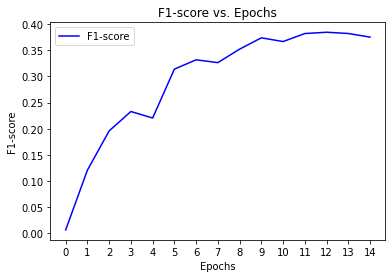

In [43]:
plot_metric(f1_scores, "F1-score")

#### Dice's coefficient

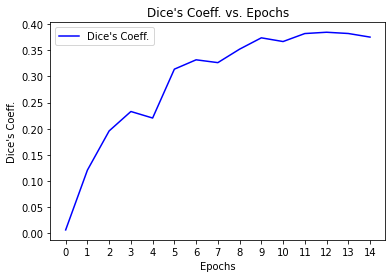

In [44]:
plot_metric(dice_coefficients, "Dice's Coeff.")

#### ROC AUC

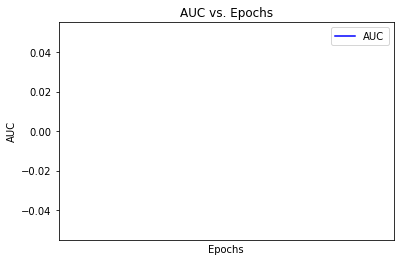

In [46]:
plot_metric(roc_auc_scores, "AUC")

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

In [19]:
from utils import plot_seg_results

In [ ]:
dataloader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, num_workers=0)
images, ground_truths = next(iter(dataloader))
outputs = model(images.cuda())
predictions = torch.argmax(outputs.squeeze().cpu(), dim = 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

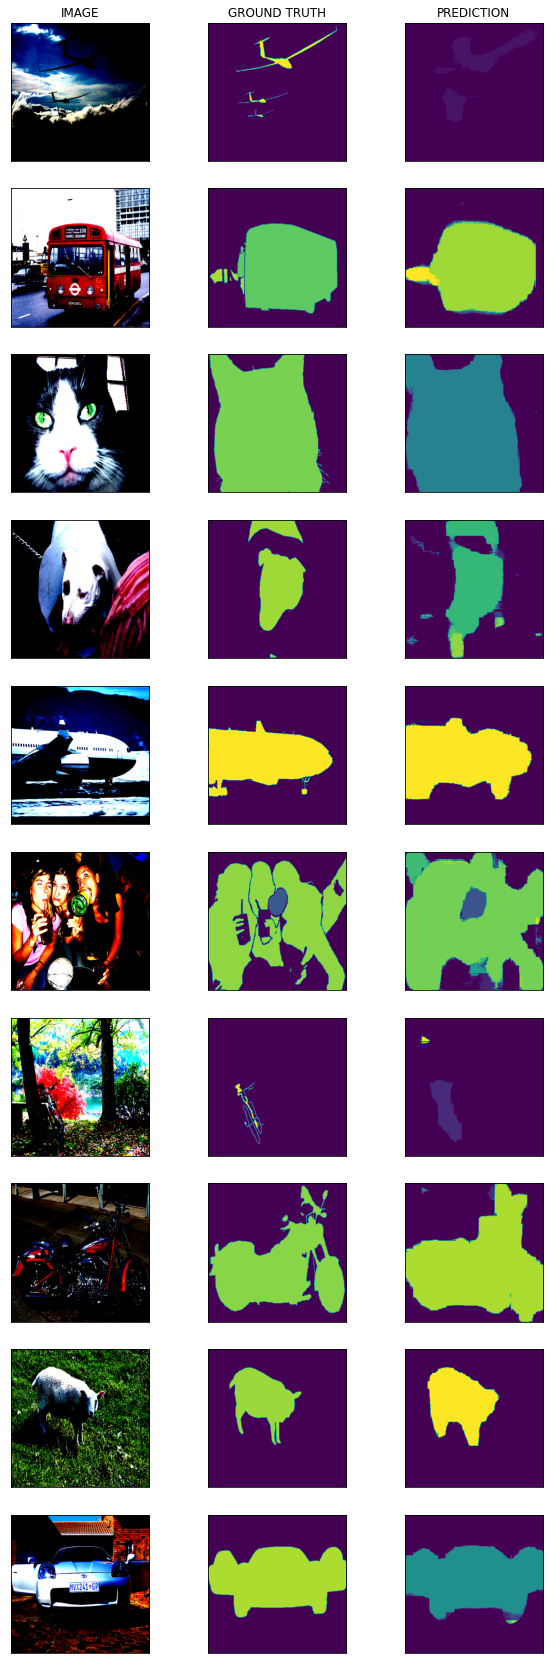

In [30]:
plot_seg_results(images, ground_truths, predictions.detach().numpy())